In [18]:
model = torch.load(model_path)
model['hyper_parameters']['autoencoder_checkpoint'] = '/home/john/PhD/BISCUIT/pretrained_models/AE_gridworld_simplified/AE_20l_64hid.ckpt'
torch.save(model, model_path)

In [1]:
from models.biscuit_nf import BISCUITNF
import torch
from typing import List, Tuple, Dict, Any, Union, Optional
device = 'cuda' if torch.cuda.is_available() else 'cpu'

autoencoder_path = '/home/john/PhD/BISCUIT/pretrained_moels/AE_gridworld_simplified/AE_20l_64hid.ckpt'
model_path = '/home/john/PhD/BISCUIT/pretrained_models/AE_gridworld_simplified/NF_text_only.ckpt'
model = BISCUITNF.load_from_checkpoint(model_path, autoencoder_path=autoencoder_path)
model.to(device)
model.freeze()
_ = model.eval()



/home/john/miniconda3/envs/biscuit/lib/python3.11/site-packages/pytorch_lightning/utilities/migration/utils.py:55: PossibleUserWarning: The loaded checkpoint was produced with Lightning v2.1.0, which is newer than your current Lightning version: v2.0.9.post0
  rank_zero_warn(
/home/john/miniconda3/envs/biscuit/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [ ]:
import torch
encs_path = '/home/john/PhD/BISCUIT/pretrained_models/AE_gridworld_simplified/encodings/gridworld_simplified_5c_test_indep.pt'
encs_path_drop_last_frame = '/home/john/PhD/BISCUIT/pretrained_models/AE_gridworld_simplified/encodings/gridworld_simplified_5c_drop_last_frame_test_indep.pt'
t = torch.load(encs_path)
t1 = torch.load(encs_path_drop_last_frame)


In [ ]:
from matplotlib import pyplot as plt
for i in range(50):
    print(i)
    img1 = t1[i]
    img2 = t[i]
    print(img1)
    print(img2)
    img1 = model.autoencoder.decoder(torch.from_numpy(img1).to(device).unsqueeze(0))
    img1 = (img1 + 1) / 2
    img2 = model.autoencoder.decoder(torch.from_numpy(img2).to(device).unsqueeze(0))
    img2 = (img2 + 1) / 2
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(img1.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
    ax[1].imshow(img2.squeeze().cpu().detach().numpy().transpose(1, 2, 0))
    plt.show()


In [ ]:
test_image = torch.tensor([[ 0.1969,  0.5175, -0.0907, -0.0496,  0.0014,  0.2527, -0.2799, -0.1513,
         0.1233,  0.3520,  0.1319,  0.1088, -0.3194,  0.2748, -0.7499, -0.1906,
         0.0959,  0.2715,  0.0838, -0.2320]]).to(device)
test_image = model.autoencoder.decoder(test_image)
test_image = (test_image + 1) / 2
plt.imshow(test_image.squeeze().cpu().detach().numpy().transpose(1, 2, 0))

In [ ]:
encodings_path = '/home/gkounto/BISCUIT/experiments/pretrained_models/AE_gridworld_small/encodings/gridworld_small_pre_intv_freeze_test.pt'
encodings = torch.load(encodings_path)

In [ ]:
from experiments.datasets import GridworldDataset
data_folder = '/home/gkounto/BISCUIT/data_generation/data/gridworld_simplified_5c'
# val_seq_dataset = GridworldDataset(
# data_folder=data_folder, split='val', return_targets=True, return_robot_state=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)
train_seq_dataset = GridworldDataset(
        data_folder=data_folder, split='train', return_targets=True, return_latents=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)

In [ ]:
train_seq_dataset[0]

In [ ]:
import numpy as np
import json
from data_generation.gridworld import Gridworld
from PIL import Image
import matplotlib.pyplot as plt

def format_causal_dict(causal_dict):
    formatted_text = ""
    for key, value in causal_dict.items():
        formatted_text += f"{key}: {value}\n"
        if "position_y" in key:  # Add a line break after each entity's details
            formatted_text += "\n"
    return formatted_text

def visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions):
    for i in range(len(frames)):
        # debug_causals = Gridworld.causal_vector_to_debug_dict(causal_keys, causals[i])
        debug_causals = dict(zip(causal_keys, causals[i]))
        formatted_causals = format_causal_dict(debug_causals)

        fig, ax = plt.subplots(figsize=(10, 6))
        ax1 = plt.subplot(1, 2, 1)  # Frame subplot
        ax1.imshow(frames[i])
        ax1.set_title(f"Frame {i+1}")
        ax1.axis('off')

        ax2 = plt.subplot(1, 2, 2)  # Textual information subplot
        ax2.axis('off')
        text_info = (
            f"Step {i+1}:\n\n"
            f"Causals (Formatted):\n{formatted_causals}\n"
            f"Action: {actions[i]}\n"
            f"Action Description: {action_descriptions[i]}\n"
            f"Interventions: {interventions[i]}"
        )
        ax2.text(0, 1, text_info, ha='left', va='top', fontsize=8, wrap=True)

        plt.tight_layout()
        plt.show()

a = np.load('/home/john/PhD/BISCUIT/data/gridworld_simplified_5c/val/gridworld_episode_10002.npz')
causal_keys = json.load(open('/home/john/PhD/BISCUIT/data/gridworld_simplified_5c/train_metadata.json'))['flattened_causals']
frames, causals, actions, interventions, action_descriptions = a['frames'], a['causals'], a['actions'], a['interventions'], a['action_descriptions']
visualize_episode(frames, causals, causal_keys, actions, action_descriptions, interventions)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import json
# Assume Gridworld, format_causal_dict, and the dataset class are defined elsewhere

def visualize_episodes(dataset, causal_keys, N=1):
    for episode_idx in range(min(N, len(dataset))):  # Loop through N episodes or the total dataset length
        frame_seq = dataset[episode_idx]  # Get the episode data
        frames, actions, interventions, causals = frame_seq
        
        for i in range(frames.shape[0] - 1):  # Iterate through each step, excluding the last frame
            # Map causals to keys for the current frame
            debug_causals = dict(zip(causal_keys, causals[i]))
            formatted_causals = format_causal_dict(debug_causals)

            fig, ax = plt.subplots(figsize=(10, 6))
            ax1 = plt.subplot(1, 2, 1)  # Frame subplot
            # Adjust image normalization if necessary
            img = (frames[i].permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0  # Normalize if required
            ax1.imshow(img)
            ax1.set_title(f"Episode {episode_idx + 1}, Frame {i + 1}")
            ax1.axis('off')

            ax2 = plt.subplot(1, 2, 2)  # Textual information subplot
            ax2.axis('off')
            text_info = (
                f"Episode {episode_idx + 1}, Step {i + 1}:\n\n"
                f"Causals (Formatted):\n{formatted_causals}\n"
                f"Action: {actions[i]}\n"
                f"Interventions: {interventions[i]}"
            )
            ax2.text(0, 1, text_info, ha='left', va='top', fontsize=8, wrap=True)

            plt.tight_layout()
            plt.show()

# Example usage:
causal_keys = json.load(open('/home/gkounto/BISCUIT/data_generation/data/gridworld_simplified/train_metadata.json'))['flattened_causals']
# Assuming train_seq_dataset is defined and loaded
visualize_episodes(train_seq_dataset, causal_keys, N=20)



In [17]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def show_img(imgs: Any,
             figure_title: str = None,
             titles: Optional[list] = None):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axes = plt.subplots(1, len(imgs), figsize=(len(imgs) * 3.5, 3.5))
    if len(imgs) == 1:
        axes = [axes]
    for i, ax in enumerate(axes):
        if len(imgs[i].shape) == 3 and imgs[i].shape[0] in [3,4]:
            imgs[i] = imgs[i].permute(1, 2, 0)
        if isinstance(imgs[i], torch.Tensor):
            imgs[i] = imgs[i].detach().cpu().numpy()
        ax.imshow(imgs[i])
        ax.axis('off')
        if titles is not None and i < len(titles):
            ax.set_title(titles[i], weight='bold')
    if figure_title is not None:
        fig.suptitle(figure_title, weight='bold', size=16)
    plt.tight_layout()
    plt.show()

def create_exclamation_mark_image(size=256, background_color=(1, 1, 1), mark_color=(1, 0, 0), mark_thickness=10, mark_height=100, dot_radius=10):
    """
    Creates an image with a red exclamation mark in the center on a white background.

    Parameters:
    - size (int): The size of the image (width and height). Default is 256.
    - background_color (tuple): The RGB color of the background in the range 0 to 1. Default is white.
    - mark_color (tuple): The RGB color of the exclamation mark in the range 0 to 1. Default is red.
    - mark_thickness (int): The thickness of the line part of the exclamation mark. Default is 10.
    - mark_height (int): The height of the line part of the exclamation mark. Default is 100.
    - dot_radius (int): The radius of the dot part of the exclamation mark. Default is 10.

    Returns:
    - numpy.ndarray: The generated image as a NumPy array.
    """
    # Create a size x size x 3 array with the background color
    image = np.ones((size, size, 3)) * np.array(background_color)

    # Define the center position
    center_x, center_y = size // 2, size // 2

    # Draw the line part of the exclamation mark
    for x in range(center_x - mark_thickness // 2, center_x + mark_thickness // 2):
        for y in range(center_y - mark_height // 2, center_y + mark_height // 2 - dot_radius * 2):
            image[y, x] = mark_color

    # Draw the dot part of the exclamation mark
    for x in range(image.shape[1]):
        for y in range(image.shape[0]):
            if (x - center_x) ** 2 + (y - (center_y + mark_height // 2 + dot_radius)) ** 2 <= dot_radius ** 2:
                image[y, x] = mark_color

    return image


@torch.no_grad()
def next_step_prediction(
        model: BISCUITNF,
        image: torch.Tensor,
        action: torch.Tensor,
        gt_image: torch.Tensor = torch.zeros(1),
        latents: Optional[torch.Tensor] = None,
        plot_images: bool = True,
        intv_targets: Optional[torch.Tensor] = None,
        text: Optional[str] = None,
        tokenizer: Optional[Any] = None,
        text_only: bool = False,
        N: int = 8
    ) -> Tuple[torch.Tensor, torch.Tensor]:
    if latents is None:
        input_image = (image * 2.0) - 1.0
        latents = model.autoencoder.encoder(input_image[None])
        latents, _ = model.flow.forward(latents)
    if text is not None:
        tokenized_description = tokenizer.tokenizer(text, return_token_type_ids=True, padding='max_length', max_length=64)
        input_ids = torch.tensor(tokenized_description['input_ids']).to(device)
        token_type_ids = torch.tensor(tokenized_description['token_type_ids']).to(device)
        attention_mask = torch.tensor(tokenized_description['attention_mask']).to(device)
        tokenized_description = {'input_ids': input_ids, 'token_type_ids': token_type_ids, 'attention_mask': attention_mask}    
    new_latents, _ = model.prior_t1.sample(latents, action[None], num_samples=1, intv_targets=intv_targets, tokenized_description=tokenized_description)
    new_latents = new_latents.squeeze(1)
    new_encodings = model.flow.reverse(new_latents)
    new_image = model.autoencoder.decoder(new_encodings)[0]
    new_image = (new_image + 1.0) / 2.0
    if plot_images:
        gt_diff_flag = False
        new_image_frame = new_image.permute(1, 2, 0).cpu().numpy()
        if latents is None:
            old_image_frame = (image.permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0
        else:
            old_image_frame = image.permute(1, 2, 0).cpu().numpy()
        clicked_image_frame = np.copy(old_image_frame)
        ground_truth_image_frame = (gt_image.permute(1, 2, 0).cpu().numpy() + 1.0) / 2.0
        difference = np.abs(new_image_frame - ground_truth_image_frame)
        print(f"Mean absolute difference between the new image and the ground truth: {difference.mean()}")
        if difference.mean() > 0.001:
            print("The new image is not close to the ground truth")
            gt_diff_flag = True
            exclamation_mark_image = create_exclamation_mark_image()
        if action.ndim == 1:
            action = action[None]
        for i in range(action.shape[0]):
            if torch.any(action < 0) or torch.any(action > 1):
                continue
            # Correct calculation for pixel positions considering the normalized action coordinates
            pixel_x = int(action[i, 0].item() * (image.shape[-1] - 1))
            pixel_y = int(action[i, 1].item() * (image.shape[-2] - 1))
            # Highlight the click location with a red color
            clicked_image_frame[max(0, pixel_y-5):pixel_y+6, 
                                max(0, pixel_x-5):pixel_x+6, 
                                :] = np.array([1.0, 1.0, 1.0])
        if torch.any(gt_image != 0):
            image_list = [old_image_frame, clicked_image_frame, new_image_frame, ground_truth_image_frame]
            image_titles = ['Previous Frame', 'Click Location', 'New Sample', 'Ground Truth']
            if gt_diff_flag:
                image_list.append(exclamation_mark_image)
                image_titles.append('Difference')
            show_img(image_list,
                     figure_title=f'Performing action {(action if action.ndim == 1 else action[0]).squeeze().cpu().numpy()}',
                     titles=image_titles)
        else:
            show_img([old_image_frame, clicked_image_frame, new_image_frame],
                    figure_title=f'Performing action {(action if action.ndim == 1 else action[0]).squeeze().cpu().numpy()}',
                    titles=['Previous Frame', 'Click Location', 'New Sample'])
    return new_image, new_latents




In [ ]:
val_dataset = GridworldDataset(
	data_folder=data_folder, split='val_indep', return_targets=False, single_image=True, return_latents=True, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=1.0,)
for elem in val_dataset:
    print(elem[0].shape)

In [5]:
from experiments.datasets import GridworldDataset
data_folder = '/home/john/PhD/BISCUIT/data/gridworld_simplified_5c'
# val_seq_dataset = GridworldDataset(
# data_folder=data_folder, split='val', return_targets=True, return_robot_state=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)
test_seq_dataset = GridworldDataset(
        data_folder=data_folder, split='test', return_targets=True, return_latents=True, single_image=False, triplet=False, seq_len=2, cluster=False, return_text=False, subsample_percentage=0.01)
val_indep_dataset = GridworldDataset(
         data_folder=data_folder, split='val_indep', return_targets=True, single_image=True, return_latents=True, triplet=False, seq_len=1, cluster=False, return_text=False, subsample_percentage=0.1)

10


Loading sequences of test:   0%|          | 0/10 [00:00<?, ?it/s]

100


In [ ]:
import torch

def reverseEnum(data: list):
    for i in range(len(data)-1, -1, -1):
        yield (i, data[i])

for i, frame_seq in enumerate(test_seq_dataset):
        print(i)
        action = torch.tensor(frame_seq[1]).to(device).squeeze()
        interventions = torch.tensor(frame_seq[2]).to(device)
        causals = torch.tensor(frame_seq[3]).to(device)
        print(causals)
        print(interventions)
        # intv_targets = torch.tensor(frame_seq[2]).to(device)
        intv_targets = None
        plot_images = True
        new_image, new_latents = next_step_prediction(model, frame_seq[0][0], action, gt_image=frame_seq[0][1], plot_images=plot_images, intv_targets=intv_targets)

In [ ]:
for i, frame_seq in enumerate(val_seq_dataset):
    # Stack the images at each step to form a sequence
    frames, actions = frame_seq
    frames = frames.to(device)
    actions = torch.from_numpy(actions).to(device)
    # interventions = interventions.to(device)
    # causals = causals.to(device)
    # Perform the next step prediction
    new_image, new_latents = next_step_prediction(frames[0], actions, gt_image=frames[1], intv_targets=None, plot_images=True)
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


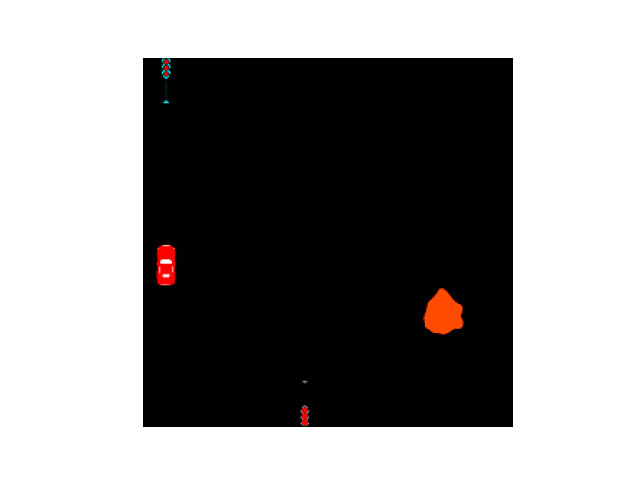

In [15]:
%matplotlib ipympl

latents = None
image = test_seq_dataset[0][0][0]

fig, ax = plt.subplots()
ax.imshow(image.permute(1, 2, 0).cpu().numpy())
load_text = ax.text(image.shape[-1]//2, 
                image.shape[-2]//2, 
                'Loading...', 
                fontsize='x-large',
                weight='bold',
                va='center',
                ha='center',
                backgroundcolor=(1.0, 0.8, 0.8))
load_text.set_visible(False)
ax.axis('off')

def onclick(event):
    print('click')
    global image, latents
    load_text.set_visible(True)
    fig.canvas.draw()
    ix, iy = event.xdata, event.ydata
    # ix = (ix / image.shape[-1] - 0.5) * 2.0
    # iy = (iy / image.shape[-2] - 0.5) * 2.0
    print(f'Clicked at x={ix}, y={iy}')
    image, latents = next_step_prediction(model, image=image,
                                            action=torch.tensor([iy, ix], 
                                                                    dtype=torch.float32,
                                                                    device=device),
                                            latents=latents,
                                            plot_images=False)
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    load_text.set_visible(False)
    fig.canvas.draw()

cid = fig.canvas.mpl_connect('button_press_event', onclick)

In [6]:
image = test_seq_dataset[5][0][0]
latents = None
action_sequence = [
    (0.42857143, 1.),
    (0., 0.),
    (-0.14285714, -0.14285714),
    (0.42857143, 1.),
    (0., 0.),
]

for i, action in enumerate(action_sequence):
    image, latents = next_step_prediction(model,
                                          image=image, 
                                          action=torch.tensor(action, device=device), 
                                          latents=latents,
                                          gt_image=test_seq_dataset[5][0][1],
                                          plot_images=True)

UnboundLocalError: cannot access local variable 'tokenized_description' where it is not associated with a value

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


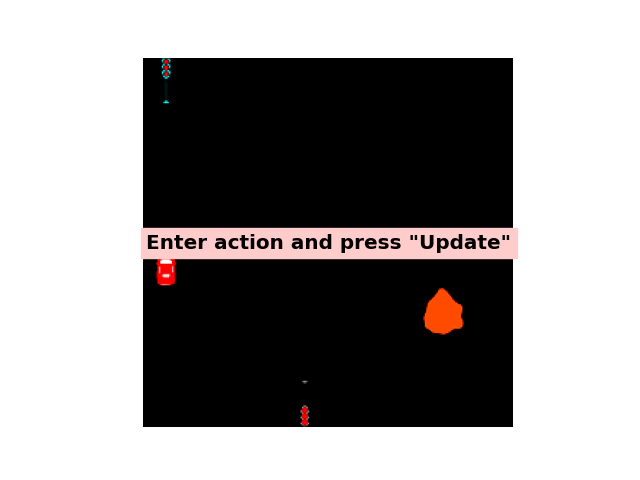

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You moved the rocky, orange obstacle.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You toggled the state of the cyan traffic light.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You toggled the state of the cyan traffic light.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You toggled the state of the cyan traffic light.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You toggled the state of the cyan traffic light.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You performed no action.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You toggled the state oaf the cyan traffic light.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You performed no action.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You performed no action.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Action: You performed no action.


In [26]:
%matplotlib ipympl
import ipywidgets as widgets
from IPython.display import display
import torch
import matplotlib.pyplot as plt
from open_clip import get_tokenizer
tokenizer = get_tokenizer('hf-hub:timm/ViT-B-16-SigLIP')
action = torch.tensor((-0.14285714, -0.14285714)).to(device)

# Assuming test_seq_dataset, next_step_prediction, and device are defined elsewhere
latents = None
image = test_seq_dataset[0][0][0]


fig, ax = plt.subplots()
ax.imshow(image.permute(1, 2, 0).cpu().numpy())
load_text = ax.text(image.shape[-1]//2, 
                    image.shape[-2]//2, 
                    'Enter action and press "Update"', 
                    fontsize='x-large',
                    weight='bold',
                    va='center',
                    ha='center',
                    backgroundcolor=(1.0, 0.8, 0.8))
load_text.set_visible(True)  # Initially visible to prompt for input
ax.axis('off')

# Text input for action
text_input = widgets.Text(
    value='',
    placeholder='Type action here',
    description='Action:',
    disabled=False
)

# Button to trigger the update
update_button = widgets.Button(
    description='Update',
    disabled=False,
    button_style='',  # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click to update based on action',
    icon='check'  # (FontAwesome names without the `fa-` prefix)
)

def on_update_button_clicked(b):
    global image, latents
    text = text_input.value  # Get the text from the input widget
    
    # Convert action_text to the format expected by next_step_prediction
    # This example assumes next_step_prediction now accepts a string action.
    # You may need to process action_text as needed for your use case.
    
    print(f'Action: {text}')  # For debugging, can be removed later

    # Update the image and latents based on the provided action
    image, latents = next_step_prediction(model,
                                          image=image,
                                          action=action,  # Assuming the function now accepts a string
                                          latents=latents,
                                          plot_images=False,
                                          text=text,
                                          tokenizer=tokenizer,
                                          text_only=True)
                                          
    
    # Update the plot with the new image
    ax.clear()  # Clear the previous image
    ax.imshow(image.permute(1, 2, 0).cpu().numpy())
    load_text.set_visible(False)  # Hide the loading text
    ax.axis('off')  # Hide axes again after redrawing
    fig.canvas.draw()  # Refresh the figure

update_button.on_click(on_update_button_clicked)

# Display the widgets
widgets.VBox([text_input, update_button])


In [14]:
model.prior_t1.text_only

True

In [16]:
text = 'You toggled the state of the cyan traffic light'
image, latents = next_step_prediction(model,
					image=image,
					action=torch.tensor(action).to(device),  # Assuming the function now accepts a string
					latents=latents,
					plot_images=False,
					text=text,
					tokenizer=tokenizer,
					text_only=True)

/tmp/ipykernel_69128/3026738566.py:86: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  new_latents, _ = model.prior_t1.sample(latents, torch.tensor(action)[None], num_samples=1, intv_targets=intv_targets, tokenized_description=tokenized_description)
